# Healthcare Cardiovascular Prediction

Business Objective: I am tasked to train an ML model to predict patient cardiovascular health with essential data from the human body such as heart rate, ECG signal, cholesterol etc.

In [1]:
# Import necessary libraries
import pycaret
import pandas as pd
import numpy as np
from pycaret.classification import *

df = pd.read_csv('02_medical_records.csv')
df.head()

,age,gender,chest_pain,resting_BP,cholesterol,fasting_BS,resting_ECG,max_HR,exercise_angina,old_peak,ST_slope,cv_issue
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:
# Convert 0s to null

columns_to_replace = ['resting_BP', 'cholesterol']

# Replace 0 with NaN
df[columns_to_replace] = df[columns_to_replace].replace(0, np.nan)

# Default Cleaning and Training

In [3]:
# normalize, remove outliers, one-hot encode
exp = setup(data=df, target='cv_issue', session_id=42)

,Description,Value
0,Session id,42
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(918, 12)"
4,Transformed data shape,"(918, 19)"
5,Transformed train set shape,"(642, 19)"
6,Transformed test set shape,"(276, 19)"
7,Ordinal features,2
8,Numeric features,6
9,Categorical features,5


In [4]:
# without feature selection
best = compare_models(include=['catboost', 'rf', 'lr'], sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8506,0.9249,0.8956,0.8470,0.8692,0.6952,0.7004,9.0970
rf,Random Forest Classifier,0.8333,0.9180,0.8760,0.8344,0.8533,0.6607,0.6654,7.5930
lr,Logistic Regression,0.8412,0.9167,0.8563,0.8591,0.8566,0.6786,0.6807,7.5190


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

# Manual Data Preprocessing steps

Based on information found in the EDA. Low importance feature not removed.

In [5]:
# normalize, remove outliers, one-hot encode
exp = setup(data=df,
            target='cv_issue',
            session_id=42,
            log_experiment=True,
            bin_numeric_features = ['age'],
            categorical_features=['gender', 'chest_pain', 'resting_ECG', 'ST_slope'],
            ordinal_features={'exercise_angina': ['No', 'Yes']},
            numeric_features=['age', 'resting_BP', 'cholesterol', 'max_HR', 'old_peak'],
            normalize=True,
            normalize_method='minmax',
            transformation=True,
            remove_outliers=True,
            experiment_name='Initial Cleaning',
            use_gpu=True)

,Description,Value
0,Session id,42
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(918, 12)"
4,Transformed data shape,"(885, 19)"
5,Transformed train set shape,"(609, 19)"
6,Transformed test set shape,"(276, 19)"
7,Ordinal features,2
8,Numeric features,5
9,Categorical features,4


In [6]:
def custom_false_negatives(y_true, y_pred):
    # Calculate the number of false negatives
    # You can use tools like sklearn.metrics to compute this
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn

# add metric to PyCaret
add_metric('false_negative', 'False Negative', custom_false_negatives)

from sklearn.metrics import log_loss

def custom_log_loss(y_true, y_pred):
    return log_loss(y_true, y_pred)

# add metric to PyCaret
add_metric('log_loss', 'Log Loss', custom_log_loss)

Name                                                         Log Loss
Display Name                                                 Log Loss
Score Function       <function custom_log_loss at 0x0000022DE63C95E0>
Scorer                                   make_scorer(custom_log_loss)
Target                                                           pred
Args                                                               {}
Greater is Better                                                True
Multiclass                                                       True
Custom                                                           True
Name: log_loss, dtype: object

In [7]:
# Due to long training time, catboost classifier will not be used. (trained for 30mins and still running...)
best = compare_models(include=['rf', 'lr'], sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,False Negative,Log Loss,TT (Sec)
rf,Random Forest Classifier,0.8474,0.9215,0.8902,0.8477,0.8664,0.6889,0.6950,3.9000,5.5010,8.4770
lr,Logistic Regression,0.8380,0.9146,0.8562,0.8546,0.8534,0.6723,0.6761,5.1000,5.8389,9.4380


Processing:   0%|          | 0/13 [00:00<?, ?it/s]

Random Forest has the highest Recall, lowest average false negative and log loss. Let's take a closer look at the learning and validation curve to understand whether the model

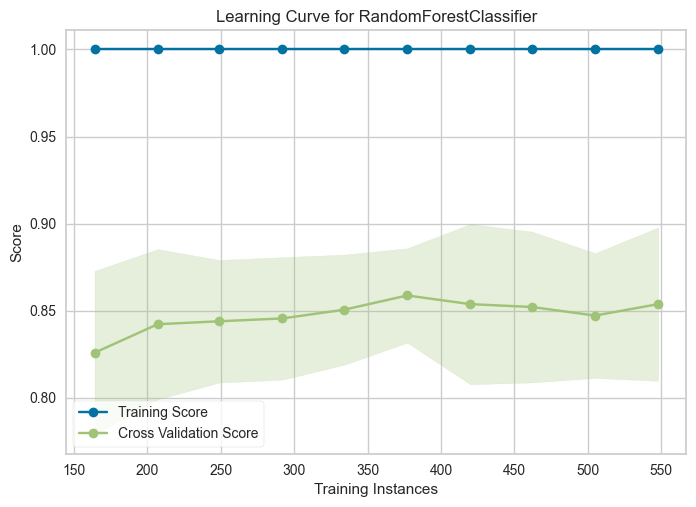

In [8]:
plot_model(best, plot = 'learning')

Clear evidence of overfitting within the Random Forest model as the training score is consistently at 1, whereas validation is around 0.85.

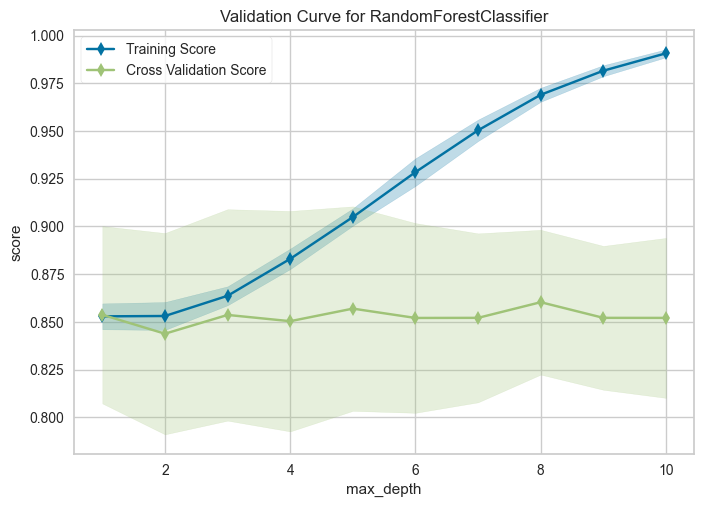

In [9]:
plot_model(best, plot = 'vc')

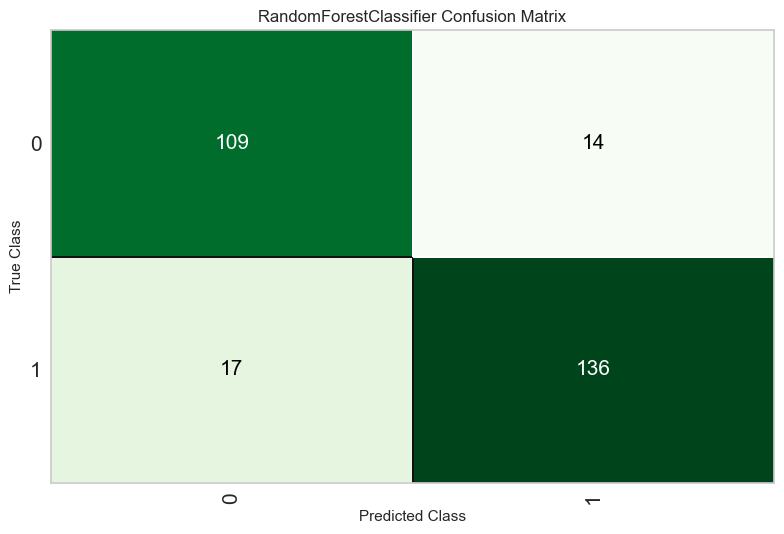

In [10]:
plot_model(best, plot = 'confusion_matrix')

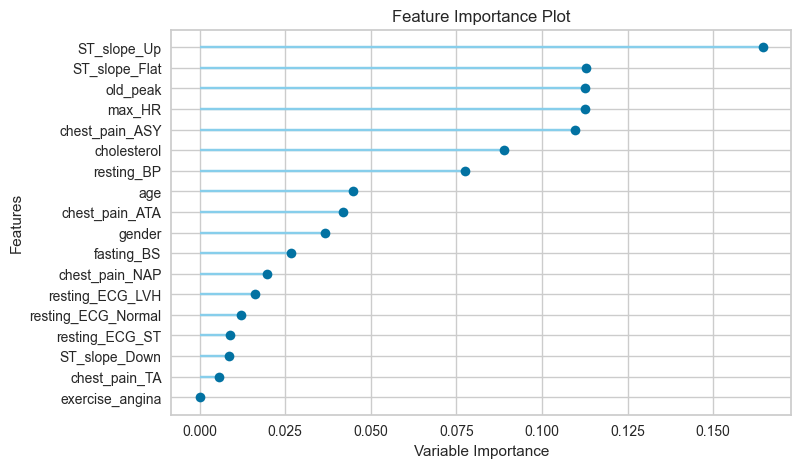

In [11]:
plot_model(best, plot = 'feature_all')

exercise_angina, fasting_BS, resting_ECG, and gender seems to have low feature importance. Therefore, will remove it.

# Further Data Preprocessing

Remove low importance features

In [29]:
exp = setup(data=df,
            target='cv_issue',
            session_id=42,
            ignore_features=['resting_ECG', 'fasting_BS', 'exercise_angina', 'gender'],
            bin_numeric_features = ['age'],
            categorical_features=['chest_pain', 'ST_slope'],
            numeric_features=['cholesterol', 'max_HR', 'old_peak', 'resting_BP'],
            normalize=True,
            normalize_method='minmax',
            transformation=True,
            remove_outliers=True,
            n_jobs=5,
            experiment_name="secondCleaning",
            use_gpu=True)

,Description,Value
0,Session id,42
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(918, 12)"
4,Transformed data shape,"(885, 13)"
5,Transformed train set shape,"(609, 13)"
6,Transformed test set shape,"(276, 13)"
7,Ignore features,4
8,Numeric features,4
9,Categorical features,2


Since the random forest model performed the best, I will perform further model tuning with random forest.

In [30]:
# train random forest with some hyper parameter tunings
rf = create_model('rf', min_samples_split=10, min_samples_leaf=15, criterion="log_loss", random_state=42)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8154,0.9234,0.8889,0.8000,0.8421,0.6214,0.6264
1,0.8308,0.8803,0.9722,0.7778,0.8642,0.6469,0.6757
2,0.8438,0.9405,0.8333,0.8824,0.8571,0.6850,0.6864
3,0.8750,0.9484,0.8889,0.8889,0.8889,0.7460,0.7460
4,0.8906,0.9246,0.9167,0.8919,0.9041,0.7769,0.7773
5,0.8906,0.9606,0.9714,0.8500,0.9067,0.7760,0.7861
6,0.8281,0.8926,0.9143,0.8000,0.8533,0.6480,0.6565
7,0.8906,0.9764,0.9714,0.8500,0.9067,0.7760,0.7861
8,0.7656,0.8305,0.8286,0.7632,0.7945,0.5229,0.5253


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

The recall increased.

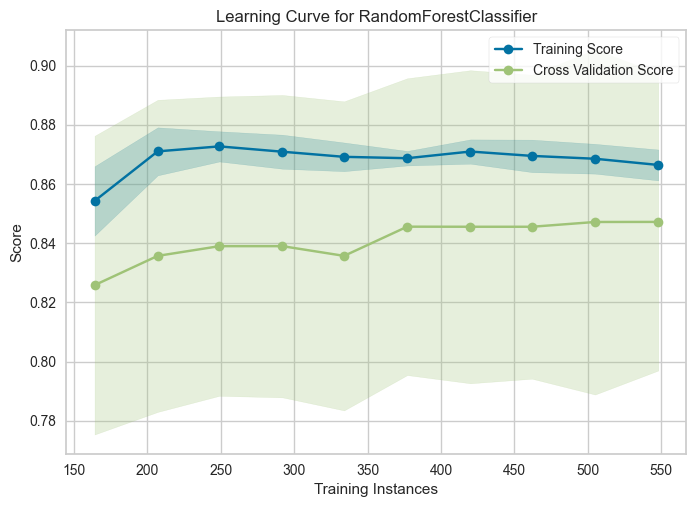

In [31]:
plot_model(rf, plot = 'learning')

Now the model difference in scores are around 4%. This is less overfitted.

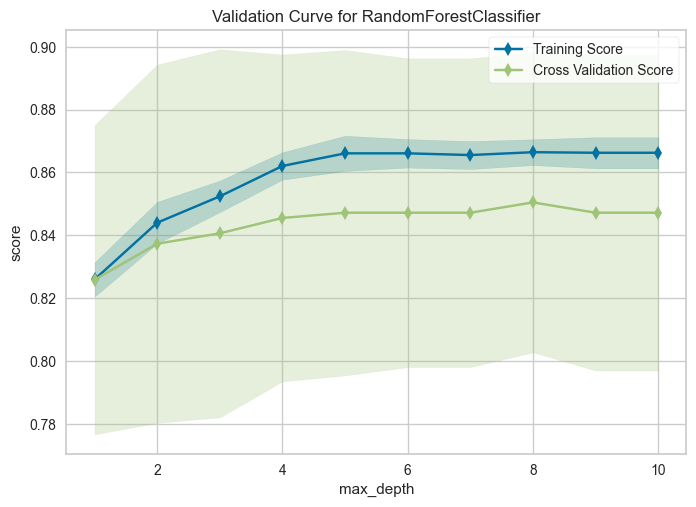

In [32]:
plot_model(rf, plot = 'vc')

The validation curve differences are also not large, around 2%.

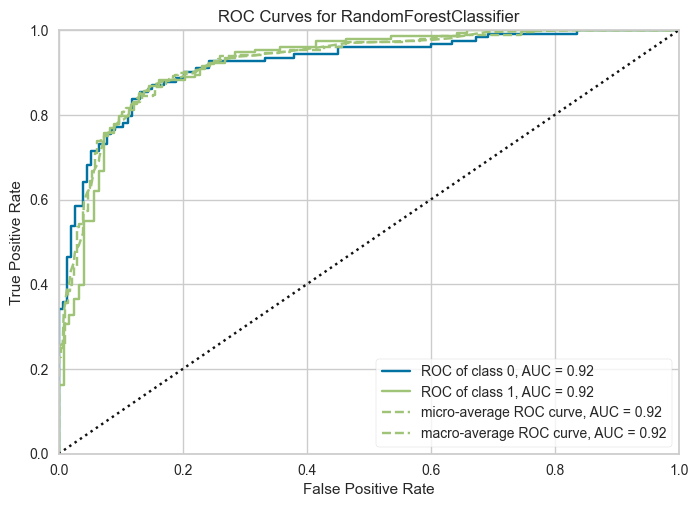

In [34]:
plot_model(rf, plot = 'auc')

The ROC of both classes are similar of 0.92, showing well ability to work with both class records.

In [35]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Looking at the gain curve, the gains for both classes are well above the baseline, showing that the model is performing quite well in both classes.

## Save the model

In [36]:
save_model(rf, 'rf_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\fangg\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['cholesterol', 'max_HR',
                                              'old_peak', 'resting_BP'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                  